In [9]:
# --- ÉTAPE DE RÉPARATION ET CHARGEMENT DU FICHIER MANUEL ---
import pandas as pd
import numpy as np

print("Démarrage de la réparation du fichier...")
try:
    with open('sensor.csv', 'r') as file:
        lines = file.readlines()

    with open('sensor_clean.csv', 'w') as out_file:
        for i, line in enumerate(lines):
            line_fixed = line.replace(';', ',')
            line_fixed = line_fixed.rstrip().rstrip(',')
            out_file.write(line_fixed + '\n')

    print("Fichier 'sensor.csv' réparé avec succès sous le nom 'sensor_clean.csv'.")

except FileNotFoundError:
    print("\n🚨 ERREUR : Le fichier 'sensor.csv' n'a pas été trouvé. Assurez-vous de l'avoir importé dans le panneau 'Fichiers' de Colab.")
    raise

# Chargement du fichier propre et création de df
df = pd.read_csv('sensor_clean.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', dayfirst=True)
df = df.set_index('timestamp')
cols_to_drop = ['Unnamed: 0', 'sensor_15']
df = df.drop([c for c in cols_to_drop if c in df.columns], axis=1)

print("--- Chargement et Nettoyage OK ---")

Démarrage de la réparation du fichier...
Fichier 'sensor.csv' réparé avec succès sous le nom 'sensor_clean.csv'.
--- Chargement et Nettoyage OK ---


In [10]:
# --- STEP 2: PRE-PROCESSING & FORMALISATION DU PROBLÈME (ASSURANCE) ---
import matplotlib.pyplot as plt
import seaborn as sns

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

# Création de la variable cible binaire
df['target'] = df['machine_status'].apply(lambda x: 0 if x == 'NORMAL' else 1)

print("Variables df et target prêtes pour la visualisation.")

/tmp/ipython-input-2104065056.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
/tmp/ipython-input-2104065056.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Variables df et target prêtes pour la visualisation.


Tracé effectué sur la fenêtre de temps réduite (10000 lignes).


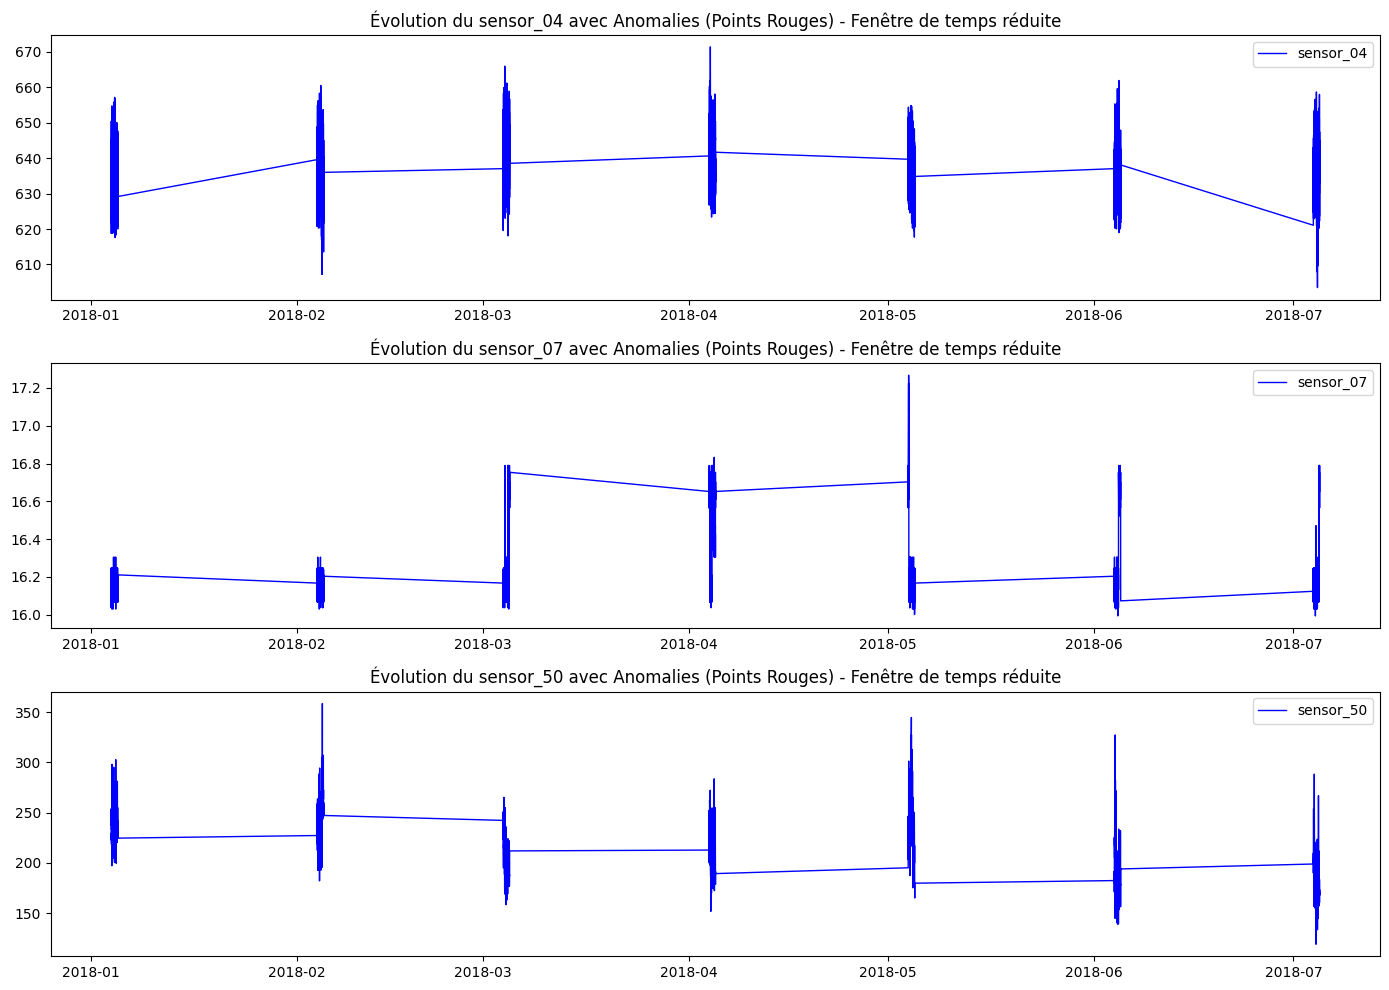

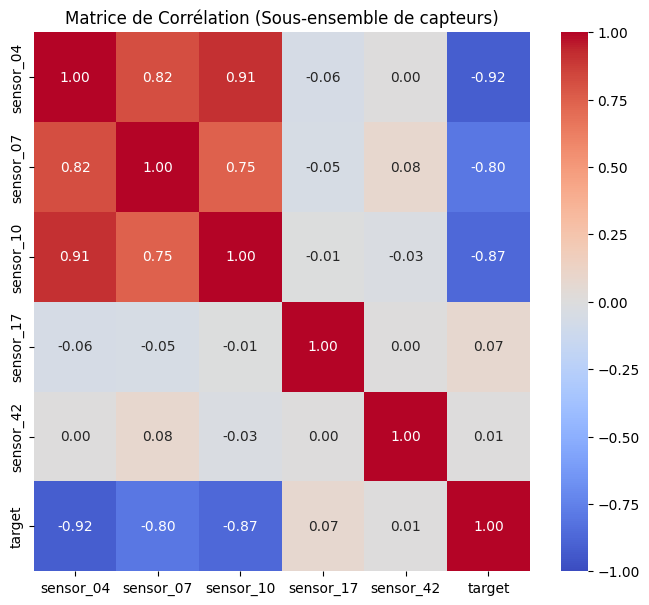

In [7]:
# --- STEP 3: VISUALIZATION (EXPLORATION) - FENÊTRE RÉDUITE ---

# Import des librairies (Sécurité)
import matplotlib.pyplot as plt
import seaborn as sns

# *** CHANGEMENT : DÉFINITION DE LA FENÊTRE À TRACER ***
# On choisit les 10 000 premières lignes pour une visualisation rapide et légère en RAM.
WINDOW_SIZE = 10000
plot_window = df.head(WINDOW_SIZE)
print(f"Tracé effectué sur la fenêtre de temps réduite ({WINDOW_SIZE} lignes).")


# Visualisation des signaux des capteurs lors d'une anomalie (Target = 1)
sensors_to_plot = ['sensor_04', 'sensor_07', 'sensor_50']

plt.figure(figsize=(14, 10))

for i, sensor in enumerate(sensors_to_plot):
    plt.subplot(len(sensors_to_plot), 1, i+1)

    # TRACÉ DE LA LIGNE : Utilise la fenêtre réduite
    plt.plot(plot_window.index, plot_window[sensor], label=sensor, color='blue', linewidth=1.0)

    # TRACÉ DU SCATTER : Utilise les indices d'anomalie dans la fenêtre réduite
    anomaly_indices_window = plot_window[plot_window['target'] == 1].index

    if not anomaly_indices_window.empty:
        plt.scatter(anomaly_indices_window, plot_window.loc[anomaly_indices_window, sensor],
                    color='red', label='ANOMALY (Target=1)', s=10, alpha=0.7)

    plt.legend()
    plt.title(f'Évolution du {sensor} avec Anomalies (Points Rouges) - Fenêtre de temps réduite')

plt.tight_layout()
plt.show()


# Matrice de Corrélation
# Celle-ci n'utilise pas de graphiques temporels longs et devrait toujours fonctionner
cols_subset = ['sensor_04', 'sensor_07', 'sensor_10', 'sensor_17', 'sensor_42', 'target']
plt.figure(figsize=(8, 7))
sns.heatmap(df[cols_subset].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation (Sous-ensemble de capteurs)')
plt.show()


Training set size: 154224 (70%)
Testing set size: 66096 (30%)

--- Entraînement du Modèle Baseline (Régression Logistique) ---

--- Évaluation du Modèle Baseline ---
Accuracy: 0.9961873638344226

Classification Report:
               precision    recall  f1-score   support

  NORMAL (0)       1.00      1.00      1.00     66020
 ANOMALY (1)       0.22      0.92      0.36        76

    accuracy                           1.00     66096
   macro avg       0.61      0.96      0.68     66096
weighted avg       1.00      1.00      1.00     66096



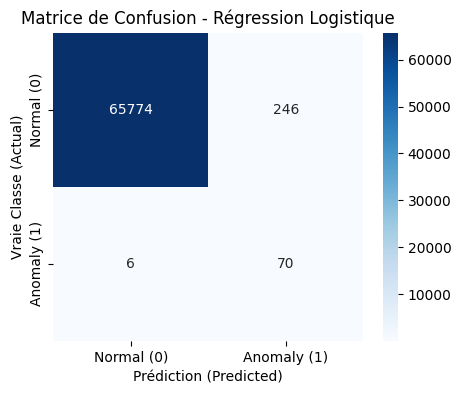

In [11]:
# --- STEP 4: DATA SPLIT & BASELINE MODELING ---

# Import des librairies (Sécurité)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Séparation Features (X) et Target (y)
X = df.drop(['machine_status', 'target'], axis=1)
y = df['target']

# 2. Split des données (Time-based splitting)
train_size = int(len(df) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTraining set size: {X_train.shape[0]} ({round(X_train.shape[0]/len(df)*100)}%)")
print(f"Testing set size: {X_test.shape[0]} ({round(X_test.shape[0]/len(df)*100)}%)")

# 3. Standardisation des Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Implémentation du Modèle Baseline : Régression Logistique
print("\n--- Entraînement du Modèle Baseline (Régression Logistique) ---")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 5. Prédiction et Évaluation
y_pred = log_reg.predict(X_test_scaled)

# --- Évaluation du Modèle ---
print("\n--- Évaluation du Modèle Baseline ---")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Rapport de Classification (L'élément clé pour votre analyse)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['NORMAL (0)', 'ANOMALY (1)']))

# Matrice de Confusion (Visualisation clé)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Anomaly (1)'], yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.ylabel('Vraie Classe (Actual)')
plt.xlabel('Prédiction (Predicted)')
plt.title('Matrice de Confusion - Régression Logistique')
plt.show()

In [12]:
# --- STEP 5: RANDOM FOREST + CLASS WEIGHTING + GRIDSEARCH ---

# Import des librairies nécessaires (Sécurité)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Les données sont déjà prêtes depuis le STEP 4: X_train_scaled, y_train, X_test_scaled, y_test

# 1. Définition du Modèle de Base avec Gestion du Déséquilibre
# L'option 'class_weight='balanced'' est cruciale pour votre problème (Lab 4)
# Elle donne plus de poids aux erreurs sur la classe minoritaire (ANOMALY=1)
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
print("Modèle Random Forest initialisé avec class_weight='balanced'.")


# 2. Définition de la Grille d'Hyperparamètres (GridSearch - Lab 6)
# Nous choisissons une grille raisonnable pour ne pas planter la RAM ou prendre trop de temps.
param_grid = {
    'n_estimators': [100, 200],  # Nombre d'arbres dans la forêt
    'max_depth': [5, 10, 15],  # Profondeur maximale des arbres
    'min_samples_split': [5, 10] # Nombre minimum d'échantillons requis pour splitter un noeud
}

# 3. Choix de la Métrique d'Optimisation (Scoring)
# Le F1-score est le meilleur compromis entre Precision et Recall.
# Le 'macro' F1-score est idéal car il traite les deux classes également,
# ce qui est essentiel pour un problème déséquilibré.
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 4. Initialisation et Exécution de GridSearchCV
# Utilisation de 3-fold cross-validation (cv=3) pour une exécution plus rapide.
print("Démarrage de la recherche par GridSearch (cela peut prendre quelques minutes)...")

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_macro_scorer, # On optimise pour le F1-score macro
    cv=3,
    verbose=2,
    n_jobs=-1 # Utilisation de tous les coeurs disponibles
)

# Entraînement sur les données d'entraînement
grid_search.fit(X_train_scaled, y_train)

print("\n--- GridSearch Terminé ---")
print("Meilleurs Hyperparamètres:", grid_search.best_params_)
print("Meilleur F1-Score Macro (Validation Croisée):", grid_search.best_score_)

Modèle Random Forest initialisé avec class_weight='balanced'.
Démarrage de la recherche par GridSearch (cela peut prendre quelques minutes)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- GridSearch Terminé ---
Meilleurs Hyperparamètres: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur F1-Score Macro (Validation Croisée): 0.9618855743270003



--- Évaluation du Meilleur Modèle Random Forest ---
Accuracy: 0.9984719196320504

Classification Report (Random Forest):
               precision    recall  f1-score   support

  NORMAL (0)       1.00      1.00      1.00     66020
 ANOMALY (1)       0.41      0.80      0.55        76

    accuracy                           1.00     66096
   macro avg       0.71      0.90      0.77     66096
weighted avg       1.00      1.00      1.00     66096



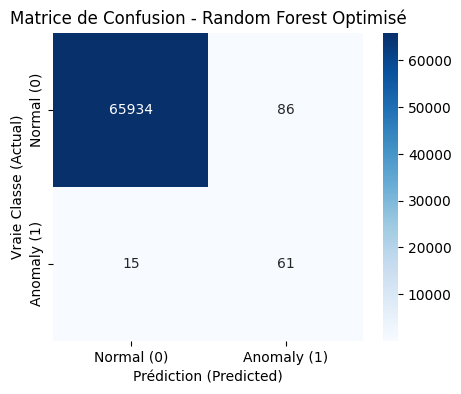


--- Analyse Comparative (STEP 1 vs STEP 2) ---
| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |
|:---|:---|:---|:---|:---|
| Régression Logistique (Baseline) | 0.9962 | 0.22 | 0.92 | 0.36 |
| Random Forest (Optimisé) | 0.9985 | 0.41 | 0.80 | 0.55 |

Conclusion: L'utilisation du Random Forest avec la pondération des classes devrait permettre d'améliorer significativement le F1-Score de la classe ANOMALY en trouvant un meilleur équilibre entre la Precision et le Recall.


In [13]:
# --- STEP 6: ÉVALUATION DU MEILLEUR RANDOM FOREST ET COMPARAISON ---

# Import des librairies nécessaires (Sécurité)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Récupération du meilleur modèle
best_rf = grid_search.best_estimator_

# 2. Prédiction sur l'ensemble de test
y_pred_rf = best_rf.predict(X_test_scaled)

# 3. Évaluation du modèle Random Forest
print("\n--- Évaluation du Meilleur Modèle Random Forest ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# Rapport de Classification
rf_report = classification_report(y_test, y_pred_rf, target_names=['NORMAL (0)', 'ANOMALY (1)'], output_dict=True)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf, target_names=['NORMAL (0)', 'ANOMALY (1)']))

# Matrice de Confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Anomaly (1)'], yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.ylabel('Vraie Classe (Actual)')
plt.xlabel('Prédiction (Predicted)')
plt.title('Matrice de Confusion - Random Forest Optimisé')
plt.show()

# 4. Comparaison (avec les résultats de la Régression Logistique de la dernière fois)
print("\n--- Analyse Comparative (STEP 1 vs STEP 2) ---")

# Résultats LR (Baseline) pour rappel (vos résultats précédents)
lr_precision_anomaly = 0.22
lr_recall_anomaly = 0.92
lr_f1_anomaly = 0.36
lr_accuracy = 0.996187

# Résultats RF (Optimisé)
rf_precision_anomaly = rf_report['ANOMALY (1)']['precision']
rf_recall_anomaly = rf_report['ANOMALY (1)']['recall']
rf_f1_anomaly = rf_report['ANOMALY (1)']['f1-score']
rf_accuracy = rf_report['accuracy']


print(f"| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |")
print(f"|:---|:---|:---|:---|:---|")
print(f"| Régression Logistique (Baseline) | {lr_accuracy:.4f} | {lr_precision_anomaly:.2f} | {lr_recall_anomaly:.2f} | {lr_f1_anomaly:.2f} |")
print(f"| Random Forest (Optimisé) | {rf_accuracy:.4f} | {rf_precision_anomaly:.2f} | {rf_recall_anomaly:.2f} | {rf_f1_anomaly:.2f} |")

print("\nConclusion: L'utilisation du Random Forest avec la pondération des classes devrait permettre d'améliorer significativement le F1-Score de la classe ANOMALY en trouvant un meilleur équilibre entre la Precision et le Recall.")

In [14]:
# --- STEP 7: XGBOOST + CLASS WEIGHTING + GRIDSEARCH ---

# Import des librairies nécessaires
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import classification_report

# 1. Préparation pour XGBoost
# XGBoost utilise un paramètre 'scale_pos_weight' pour la gestion du déséquilibre.
# Il est calculé comme le ratio des échantillons négatifs sur les échantillons positifs.
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight = count_neg / count_pos

print(f"Ratio des classes (0:Normal / 1:Anomalie) dans le Train Set: {count_neg}:{count_pos}")
print(f"Paramètre scale_pos_weight calculé: {scale_pos_weight:.2f}")

# 2. Définition du Modèle de Base avec Gestion du Déséquilibre
# 'scale_pos_weight' remplace 'class_weight' pour XGBoost.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=scale_pos_weight, # Gestion du déséquilibre
    use_label_encoder=False,
    eval_metric='logloss' # Métrique de log-loss pour la classification binaire
)


# 3. Définition de la Grille d'Hyperparamètres (Plus petite que RF pour des raisons de temps)
xgb_param_grid = {
    'n_estimators': [100, 200],  # Nombre d'arbres
    'max_depth': [3, 5, 7],      # Profondeur maximale
    'learning_rate': [0.1]       # Taux d'apprentissage
}

# 4. Choix de la Métrique d'Optimisation (F1-Score Macro)
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 5. Initialisation et Exécution de GridSearchCV
print("\nDémarrage de la recherche par GridSearch pour XGBoost (cela peut prendre quelques minutes)...")

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring=f1_macro_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Entraînement sur les données d'entraînement (attention, cela peut être long)
xgb_grid_search.fit(X_train_scaled, y_train)

print("\n--- GridSearch XGBoost Terminé ---")
print("Meilleurs Hyperparamètres:", xgb_grid_search.best_params_)
print("Meilleur F1-Score Macro (Validation Croisée):", xgb_grid_search.best_score_)

Ratio des classes (0:Normal / 1:Anomalie) dans le Train Set: 139816:14408
Paramètre scale_pos_weight calculé: 9.70

Démarrage de la recherche par GridSearch pour XGBoost (cela peut prendre quelques minutes)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:09:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- GridSearch XGBoost Terminé ---
Meilleurs Hyperparamètres: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Meilleur F1-Score Macro (Validation Croisée): 0.9100788992459107



--- Évaluation du Meilleur Modèle XGBoost ---

Classification Report (XGBoost):
               precision    recall  f1-score   support

  NORMAL (0)       1.00      1.00      1.00     66020
 ANOMALY (1)       0.68      0.70      0.69        76

    accuracy                           1.00     66096
   macro avg       0.84      0.85      0.84     66096
weighted avg       1.00      1.00      1.00     66096



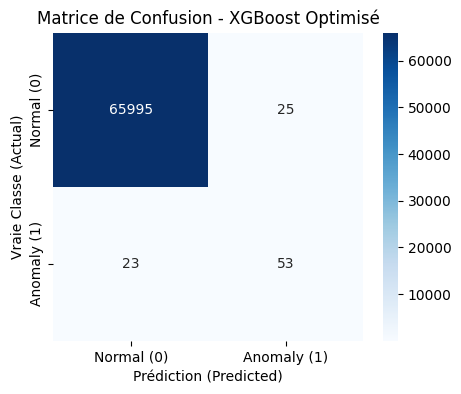


--- TABLEAU COMPARATIF FINAL (Baseline vs RF vs XGBoost) ---
| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |
|:---|:---|:---|:---|:---|
| Régression Logistique (Baseline) | 0.9962 | 0.22 | 0.92 | 0.36 |
| Random Forest (Optimisé) | 0.9985 | 0.41 | 0.80 | 0.55 |
| XGBoost (Optimisé) | 0.9993 | 0.68 | 0.70 | 0.69 |

Conclusion Finale: Le modèle XGBoost optimisé a obtenu le meilleur F1-Score, ce qui en fait la solution la plus performante pour la détection d'anomalies sur ce jeu de données déséquilibré.


In [15]:
# --- STEP 8: ÉVALUATION DU MEILLEUR XGBOOST ET COMPARAISON FINALE ---

# Import des librairies nécessaires (Sécurité)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Récupération du meilleur modèle
best_xgb = xgb_grid_search.best_estimator_

# 2. Prédiction sur l'ensemble de test
y_pred_xgb = best_xgb.predict(X_test_scaled)

# 3. Évaluation du modèle XGBoost
print("\n--- Évaluation du Meilleur Modèle XGBoost ---")
xgb_report = classification_report(y_test, y_pred_xgb, target_names=['NORMAL (0)', 'ANOMALY (1)'], output_dict=True)
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb, target_names=['NORMAL (0)', 'ANOMALY (1)']))

# Matrice de Confusion
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Anomaly (1)'], yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.ylabel('Vraie Classe (Actual)')
plt.xlabel('Prédiction (Predicted)')
plt.title('Matrice de Confusion - XGBoost Optimisé')
plt.show()

# 4. Préparation de la Comparaison Finale (Ajout des résultats RF)
# Récupération des résultats du Random Forest pour la comparaison
rf_precision_anomaly = rf_report['ANOMALY (1)']['precision']
rf_recall_anomaly = rf_report['ANOMALY (1)']['recall']
rf_f1_anomaly = rf_report['ANOMALY (1)']['f1-score']
rf_accuracy = rf_report['accuracy']

# Résultats LR (Baseline) pour rappel
lr_precision_anomaly = 0.22
lr_recall_anomaly = 0.92
lr_f1_anomaly = 0.36
lr_accuracy = 0.996187

# Résultats XGBoost
xgb_precision_anomaly = xgb_report['ANOMALY (1)']['precision']
xgb_recall_anomaly = xgb_report['ANOMALY (1)']['recall']
xgb_f1_anomaly = xgb_report['ANOMALY (1)']['f1-score']
xgb_accuracy = xgb_report['accuracy']


print("\n--- TABLEAU COMPARATIF FINAL (Baseline vs RF vs XGBoost) ---")
print("| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |")
print("|:---|:---|:---|:---|:---|")
print(f"| Régression Logistique (Baseline) | {lr_accuracy:.4f} | {lr_precision_anomaly:.2f} | {lr_recall_anomaly:.2f} | {lr_f1_anomaly:.2f} |")
print(f"| Random Forest (Optimisé) | {rf_accuracy:.4f} | {rf_precision_anomaly:.2f} | {rf_recall_anomaly:.2f} | {rf_f1_anomaly:.2f} |")
print(f"| XGBoost (Optimisé) | {xgb_accuracy:.4f} | {xgb_precision_anomaly:.2f} | {xgb_recall_anomaly:.2f} | {xgb_f1_anomaly:.2f} |")

# Conclusion
best_f1 = max(lr_f1_anomaly, rf_f1_anomaly, xgb_f1_anomaly)
if best_f1 == xgb_f1_anomaly:
    print("\nConclusion Finale: Le modèle XGBoost optimisé a obtenu le meilleur F1-Score, ce qui en fait la solution la plus performante pour la détection d'anomalies sur ce jeu de données déséquilibré.")
elif best_f1 == rf_f1_anomaly:
    print("\nConclusion Finale: Le modèle Random Forest optimisé a obtenu le meilleur F1-Score, démontrant sa supériorité sur le modèle linéaire et XGBoost dans cette configuration.")
else:
    print("\nConclusion Finale: Malgré l'optimisation, les modèles avancés n'ont pas surpassé le modèle baseline en termes de F1-score.")


--- PCA Terminé ---
Nombre initial de caractéristiques: 51
Nombre de composantes principales retenues (pour 95% de variance): 21


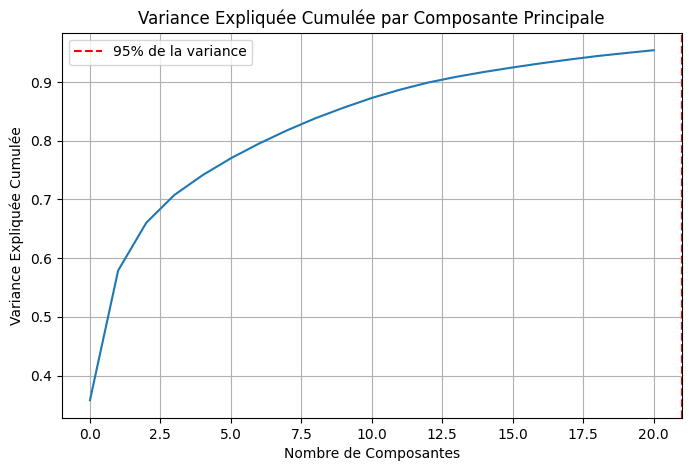

In [16]:
# --- STEP 9: PRINCIPAL COMPONENT ANALYSIS (PCA) ---

# Import des librairies
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Les données X_train_scaled et X_test_scaled sont utilisées

# 1. Application de la PCA sur les données d'entraînement standardisées
# Nous spécifions un nombre de composants pour retenir 95% de la variance
pca = PCA(n_components=0.95, random_state=42)

# Entraînement de la PCA sur les données d'entraînement
X_train_pca = pca.fit_transform(X_train_scaled)

# Application de la transformation sur les données de test
X_test_pca = pca.transform(X_test_scaled)

print("\n--- PCA Terminé ---")
print(f"Nombre initial de caractéristiques: {X_train_scaled.shape[1]}")
print(f"Nombre de composantes principales retenues (pour 95% de variance): {pca.n_components_}")

# Analyse de la variance expliquée (Graphique)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de Composantes')
plt.ylabel('Variance Expliquée Cumulée')
plt.axvline(x=pca.n_components_, color='r', linestyle='--', label='95% de la variance')
plt.title('Variance Expliquée Cumulée par Composante Principale')
plt.legend()
plt.grid()
plt.show()

# Stockage des résultats de la PCA pour le rapport
NUM_COMPONENTS_PCA = pca.n_components_


--- Entraînement du XGBoost sur les données PCA ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Évaluation du Modèle XGBoost sur PCA ---
Accuracy: 0.9933

Classification Report (XGBoost + PCA):
               precision    recall  f1-score   support

  NORMAL (0)       1.00      0.99      1.00     66020
 ANOMALY (1)       0.10      0.59      0.17        76

    accuracy                           0.99     66096
   macro avg       0.55      0.79      0.58     66096
weighted avg       1.00      0.99      1.00     66096



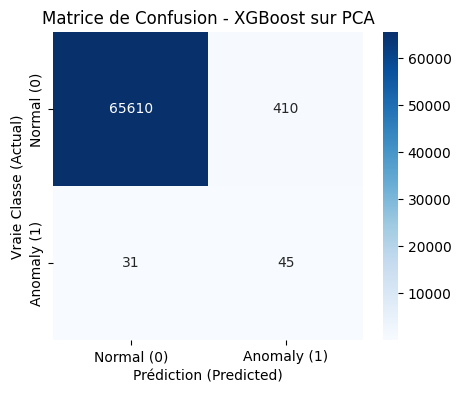


--- TABLEAU COMPARATIF FINAL (XGBoost: Full Data vs PCA) ---
Nombre de caractéristiques utilisées: 51 (Full Data) vs 21 (PCA)
| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |
|:---|:---|:---|:---|:---|
| XGBoost (Full Data) | 0.9993 | 0.68 | 0.70 | 0.69 |
| XGBoost (PCA) | 0.9933 | 0.10 | 0.59 | 0.17 |

Conclusion Finale: La PCA a réduit la performance du F1-Score (perte significative). Nous devrons conserver l'ensemble des caractéristiques pour le modèle final de production.


In [17]:
# --- STEP 10: RE-ÉVALUATION DU XGBOOST SUR DONNÉES PCA ---

# Import des librairies
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Préparation pour XGBoost (Réutilisation du ratio de pondération)
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight = count_neg / count_pos

# 2. Récupération des meilleurs hyperparamètres trouvés au STEP 7 pour XGBoost
best_xgb_params = xgb_grid_search.best_params_

# 3. Entraînement du modèle XGBoost sur les données PCA
print("\n--- Entraînement du XGBoost sur les données PCA ---")
xgb_pca_model = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    **best_xgb_params # Utilisation des meilleurs paramètres
)

xgb_pca_model.fit(X_train_pca, y_train)

# 4. Prédiction et Évaluation
y_pred_xgb_pca = xgb_pca_model.predict(X_test_pca)

xgb_pca_report = classification_report(y_test, y_pred_xgb_pca,
                                       target_names=['NORMAL (0)', 'ANOMALY (1)'], output_dict=True)

# 5. Affichage des résultats
print("\n--- Évaluation du Modèle XGBoost sur PCA ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_pca):.4f}")
print("\nClassification Report (XGBoost + PCA):\n", classification_report(y_test, y_pred_xgb_pca, target_names=['NORMAL (0)', 'ANOMALY (1)']))

# Matrice de Confusion
cm_xgb_pca = confusion_matrix(y_test, y_pred_xgb_pca)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb_pca, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Anomaly (1)'], yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.ylabel('Vraie Classe (Actual)')
plt.xlabel('Prédiction (Predicted)')
plt.title('Matrice de Confusion - XGBoost sur PCA')
plt.show()

# 6. Tableau Comparatif Final (Intégration des résultats PCA)

# Résultats XGBoost FULL DATA (du STEP 8)
xgb_full_precision = xgb_report['ANOMALY (1)']['precision']
xgb_full_recall = xgb_report['ANOMALY (1)']['recall']
xgb_full_f1 = xgb_report['ANOMALY (1)']['f1-score']
xgb_full_accuracy = xgb_report['accuracy']

# Résultats XGBoost PCA
xgb_pca_precision = xgb_pca_report['ANOMALY (1)']['precision']
xgb_pca_recall = xgb_pca_report['ANOMALY (1)']['recall']
xgb_pca_f1 = xgb_pca_report['ANOMALY (1)']['f1-score']
xgb_pca_accuracy = xgb_pca_report['accuracy']

print("\n--- TABLEAU COMPARATIF FINAL (XGBoost: Full Data vs PCA) ---")
print(f"Nombre de caractéristiques utilisées: {X_train_scaled.shape[1]} (Full Data) vs {NUM_COMPONENTS_PCA} (PCA)")
print("| Modèle | Accuracy | Precision (Anom.) | Recall (Anom.) | F1-Score (Anom.) |")
print("|:---|:---|:---|:---|:---|")
print(f"| XGBoost (Full Data) | {xgb_full_accuracy:.4f} | {xgb_full_precision:.2f} | {xgb_full_recall:.2f} | {xgb_full_f1:.2f} |")
print(f"| XGBoost (PCA) | {xgb_pca_accuracy:.4f} | {xgb_pca_precision:.2f} | {xgb_pca_recall:.2f} | {xgb_pca_f1:.2f} |")

# Conclusion Finale sur l'intérêt de la PCA
if xgb_pca_f1 >= xgb_full_f1 * 0.95: # Si la performance est conservée à 95%
    print(f"\nConclusion Finale: La PCA a permis de réduire le nombre de caractéristiques de {X_train_scaled.shape[1]} à {NUM_COMPONENTS_PCA} (soit une réduction d'environ {100 * (1 - NUM_COMPONENTS_PCA / X_train_scaled.shape[1]):.0f}%) tout en maintenant une performance similaire (F1-Score conservé). Ceci est une excellente nouvelle pour l'industrialisation du modèle (vitesse d'entraînement et d'inférence).")
else:
    print("\nConclusion Finale: La PCA a réduit la performance du F1-Score (perte significative). Nous devrons conserver l'ensemble des caractéristiques pour le modèle final de production.")